In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
path = "/content/drive/Shareddrives/Unlimited/Colab/AlphaVision/"
MODEL = "densenet161_Kfold"
model_path = "models_" + MODEL + "/"

# 1. 데이터 불러오기

In [ ]:
from google.colab import output
# !cp 파일1 파일2 # 파일1을 파일2로 복사 붙여넣기
!cp "/content/drive/Shareddrives/Unlimited/Colab/AlphaVision/AlphaVision.zip" "data_2.zip"
# data_2.zip을 현재 디렉터리에 압축해제
!unzip "data_2.zip"

Archive:  data_2.zip
replace dirty_mnist_2nd.zip? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

In [ ]:
from google.colab import output
# 현재 디렉터리에 dirty_mnist라는 폴더 생성
!mkdir "./dirty_mnist"
#dirty_mnist.zip라는 zip파일을 dirty_mnist라는 폴더에 압축 풀기
!unzip "dirty_mnist_2nd.zip" -d "./dirty_mnist/"
# 현재 디렉터리에 test_dirty_mnist라는 폴더 생성
!mkdir "./test_dirty_mnist"
#test_dirty_mnist.zip라는 zip파일을 test_dirty_mnist라는 폴더에 압축 풀기
!unzip "test_dirty_mnist_2nd.zip" -d "./test_dirty_mnist/"
# 출력 결과 지우기
output.clear()

# 2. 라이브러리 임포트

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import cv2
from tqdm import tqdm
import imutils
import zipfile
import os
from PIL import Image

import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.models as models
import torchvision.transforms as T
from torch.utils.data import DataLoader, Dataset
from google.colab import output

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu") # 디바이스 설정

# 3. 데이터 구성

In [ ]:
dirty_mnist_answer = pd.read_csv("dirty_mnist_2nd_answer.csv")
# dirty_mnist라는 디렉터리 속에 들어있는 파일들의 이름을 
# namelist라는 변수에 저장
namelist = os.listdir('./dirty_mnist/')

# numpy를 tensor로 변환하는 ToTensor 정의
class ToTensor(object):
    """numpy array를 tensor(torch)로 변환합니다."""
    def __call__(self, sample):
        image, label = sample['image'], sample['label']
        # swap color axis because
        # numpy image: H x W x C
        # torch image: C X H X W
        image = image.transpose((2, 0, 1))
        return {'image': torch.FloatTensor(image),
                'label': torch.FloatTensor(label)}
# to_tensor 선언
to_tensor = T.Compose([
                        ToTensor()
                    ])

class DatasetMNIST(torch.utils.data.Dataset):
    def __init__(self,
                 dir_path,
                 meta_df,
                 transforms=to_tensor,#미리 선언한 to_tensor를 transforms로 받음
                 augmentations=None):
        
        self.dir_path = dir_path # 데이터의 이미지가 저장된 디렉터리 경로
        self.meta_df = meta_df # 데이터의 인덱스와 정답지가 들어있는 DataFrame

        self.transforms = transforms# Transform
        self.augmentations = augmentations # Augmentation
        
    def __len__(self):
        return len(self.meta_df)
    
    def __getitem__(self, index):
        # 폴더 경로 + 이미지 이름 + .png => 파일의 경로
        # 참고) "12".zfill(5) => 000012
        #       "146".zfill(5) => 000145
        # cv2.IMREAD_GRAYSCALE : png파일을 채널이 1개인 GRAYSCALE로 읽음
        image = cv2.imread(self.dir_path +\
                           str(self.meta_df.iloc[index,0]).zfill(5) + '.png',
                           cv2.IMREAD_GRAYSCALE)
        # 0 ~ 255의 값을 갖고 크기가 (256,256)인 numpy array를
        # 0 ~ 1 사이의 실수를 갖고 크기가 (256,256,1)인 numpy array로 변환
        image = (image/255).astype('float')[..., np.newaxis]

        # 정답 numpy array생성(존재하면 1 없으면 0)
        label = self.meta_df.iloc[index, 1:].values.astype('float')
        sample = {'image': image, 'label': label}

        # transform 적용
        # numpy to tensor
        if self.transforms:
            sample = self.transforms(sample)

        # sample 반환
        return sample

# 4. 학습 모델 구성

In [ ]:
# nn.Module을 상속 받아 MultiLabelResnet를 정의
class MultiLabelDensenet(nn.Module):
    def __init__(self):
        super(MultiLabelDensenet, self).__init__()
        self.conv2d = nn.Conv2d(1, 3, 3, stride=1)
        self.densenet = models.densenet161() 
        self.FC = nn.Linear(1000, 26)

    def forward(self, x):
        # resnet의 입력은 [3, N, N]으로
        # 3개의 채널을 갖기 때문에
        # resnet 입력 전에 conv2d를 한 층 추가
        x = F.relu(self.conv2d(x))

        # resnet18을 추가
        x = F.relu(self.densenet(x))

        # 마지막 출력에 nn.Linear를 추가
        # multilabel을 예측해야 하기 때문에
        # softmax가 아닌 sigmoid를 적용
        x = torch.sigmoid(self.FC(x))
        return x
# 모델 선언
model = MultiLabelDensenet()
model

MultiLabelDensenet(
  (conv2d): Conv2d(1, 3, kernel_size=(3, 3), stride=(1, 1))
  (densenet): DenseNet(
    (features): Sequential(
      (conv0): Conv2d(3, 96, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (norm0): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu0): ReLU(inplace=True)
      (pool0): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (denseblock1): _DenseBlock(
        (denselayer1): _DenseLayer(
          (norm1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (relu1): ReLU(inplace=True)
          (conv1): Conv2d(96, 192, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (norm2): BatchNorm2d(192, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (relu2): ReLU(inplace=True)
          (conv2): Conv2d(192, 48, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        )
        (denselayer2):

# 5. 학습

In [ ]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
print(gpu_info)

Mon Feb 22 09:57:27 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.39       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla V100-SXM2...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   37C    P0    23W / 300W |      2MiB / 16160MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
# cross validation을 적용하기 위해 KFold 생성
from sklearn.model_selection import KFold
kfold = KFold(n_splits=5, shuffle=True, random_state=0)

# dirty_mnist_answer에서 train_idx와 val_idx를 생성
best_models = [] # 폴드별로 가장 validation acc가 높은 모델 저장
for fold_index, (trn_idx, val_idx) in enumerate(kfold.split(dirty_mnist_answer),1):
    print(f'[fold: {fold_index}]')
    # cuda cache 초기화
    torch.cuda.empty_cache()

    #train fold, validation fold 분할
    train_answer = dirty_mnist_answer.iloc[trn_idx]
    test_answer  = dirty_mnist_answer.iloc[val_idx]

    #Dataset 정의
    train_dataset = DatasetMNIST("dirty_mnist/", train_answer)
    valid_dataset = DatasetMNIST("dirty_mnist/", test_answer)

    #DataLoader 정의
    train_data_loader = DataLoader(
        train_dataset,
        batch_size = 32,
        shuffle = False,
        num_workers = 3
    )
    valid_data_loader = DataLoader(
        valid_dataset,
        batch_size = 32,
        shuffle = False,
        num_workers = 3
    )

    # 모델 선언
    model = MultiLabelDensenet()
    model.to(device)# gpu에 모델 할당

    # 훈련 옵션 설정
    optimizer = torch.optim.Adam(model.parameters(),
                                lr = 0.001)
    lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer,
                                                step_size = 1,
                                                gamma = 0.75)
    criterion = torch.nn.BCELoss()

    # 훈련 시작
    valid_acc_max = 0
    for epoch in range(10):
        # 1개 epoch 훈련
        train_acc_list = []
        with tqdm(train_data_loader,#train_data_loader를 iterative하게 반환
                total=train_data_loader.__len__(), # train_data_loader의 크기
                unit="batch") as train_bar:# 한번 반환하는 smaple의 단위는 "batch"
            for sample in train_bar:
                train_bar.set_description(f"Train Epoch {epoch}")
                # 갱신할 변수들에 대한 모든 변화도를 0으로 초기화
                # 참고)https://tutorials.pytorch.kr/beginner/pytorch_with_examples.html
                optimizer.zero_grad()
                images, labels = sample['image'], sample['label']
                # tensor를 gpu에 올리기
                images = images.to(device)
                labels = labels.to(device)

                # 모델의 dropoupt, batchnormalization를 train 모드로 설정
                model.train()
                # .forward()에서 중간 노드의 gradient를 계산
                with torch.set_grad_enabled(True):
                    # 모델 예측
                    probs  = model(images)
                    # loss 계산
                    loss = criterion(probs, labels)
                    # 중간 노드의 gradient로
                    # backpropagation을 적용하여
                    # gradient 계산
                    loss.backward()
                    # weight 갱신
                    optimizer.step()

                    # train accuracy 계산
                    probs  = probs.cpu().detach().numpy()
                    labels = labels.cpu().detach().numpy()
                    preds = probs > 0.5
                    batch_acc = (labels == preds).mean()
                    train_acc_list.append(batch_acc)
                    train_acc = np.mean(train_acc_list)

                # 현재 progress bar에 현재 미니배치의 loss 결과 출력
                train_bar.set_postfix(train_loss= loss.item(),
                                      train_acc = train_acc)
                

        # 1개 epoch학습 후 Validation 점수 계산
        valid_acc_list = []
        with tqdm(valid_data_loader,
                total=valid_data_loader.__len__(),
                unit="batch") as valid_bar:
            for sample in valid_bar:
                valid_bar.set_description(f"Valid Epoch {epoch}")
                optimizer.zero_grad()
                images, labels = sample['image'], sample['label']
                images = images.to(device)
                labels = labels.to(device)

                # 모델의 dropoupt, batchnormalization를 eval모드로 설정
                model.eval()
                # .forward()에서 중간 노드의 gradient를 계산
                with torch.no_grad():
                    # validation loss만을 계산
                    probs  = model(images)
                    valid_loss = criterion(probs, labels)

                    # train accuracy 계산
                    probs  = probs.cpu().detach().numpy()
                    labels = labels.cpu().detach().numpy()
                    preds = probs > 0.5
                    batch_acc = (labels == preds).mean()
                    valid_acc_list.append(batch_acc)

                valid_acc = np.mean(valid_acc_list)
                valid_bar.set_postfix(valid_loss = valid_loss.item(),
                                      valid_acc = valid_acc)
            
        # Learning rate 조절
        lr_scheduler.step()

        # 모델 저장
        if valid_acc_max < valid_acc:
            valid_acc_max = valid_acc
            best_model = model
            # 모델을 저장할 구글 드라이브 경로
            torch.save(best_model, f'{path + model_path}{fold_index}_{MODEL}_{valid_loss.item():2.4f}_epoch_{epoch}.pth')

    # 폴드별로 가장 좋은 모델 저장
    best_models.append(best_model)


[fold: 1]


Valid Epoch 9: 100%|██████████| 313/313 [00:39<00:00,  8.02batch/s, valid_acc=0.604, valid_loss=0.637]


[fold: 2]


Valid Epoch 9: 100%|██████████| 313/313 [00:39<00:00,  7.99batch/s, valid_acc=0.589, valid_loss=0.664]


[fold: 3]


Valid Epoch 9: 100%|██████████| 313/313 [00:39<00:00,  7.98batch/s, valid_acc=0.574, valid_loss=0.685]


[fold: 4]


Valid Epoch 9: 100%|██████████| 313/313 [00:39<00:00,  8.02batch/s, valid_acc=0.569, valid_loss=0.691]


[fold: 5]


Valid Epoch 9: 100%|██████████| 313/313 [00:39<00:00,  8.02batch/s, valid_acc=0.583, valid_loss=0.685]


# 6. 학습 결과 확인

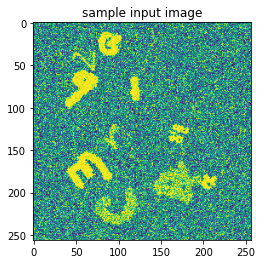

예측값 :  Index(['b', 'c', 'e', 'g', 'j', 'p', 'q', 's', 'u', 'v'], dtype='object')
정답값 :  Index(['c', 'g', 'i', 'p', 'q', 'r', 't', 'w', 'y', 'z'], dtype='object')


In [ ]:
# gpu에 올라가 있는 tensor -> cpu로 이동 -> numpy array로 변환
sample_images = images.cpu().detach().numpy()
sample_prob = probs
sample_labels = labels

idx = 1
plt.imshow(sample_images[idx][0])
plt.title("sample input image")
plt.show()

print('예측값 : ',dirty_mnist_answer.columns[1:][sample_prob[idx] > 0.5])
print('정답값 : ', dirty_mnist_answer.columns[1:][sample_labels[idx] > 0.5])


# 7. 앙상블 적용



In [ ]:
#test Dataset 정의
sample_submission = pd.read_csv("sample_submission.csv")
test_dataset = DatasetMNIST("test_dirty_mnist/", sample_submission)
batch_size = 128
test_data_loader = DataLoader(
    test_dataset,
    batch_size = batch_size,
    shuffle = False,
    num_workers = 3,
    drop_last = False
)

In [ ]:
predictions_list = []
# 배치 단위로 추론
prediction_df = pd.read_csv("sample_submission.csv")

# 5개의 fold마다 가장 좋은 모델을 이용하여 예측
for model in best_models:
    # 0으로 채워진 array 생성
    prediction_array = np.zeros([prediction_df.shape[0],
                                 prediction_df.shape[1] -1])
    for idx, sample in enumerate(test_data_loader):
        with torch.no_grad():
            # 추론
            model.eval()
            images = sample['image']
            images = images.to(device)
            probs  = model(images)
            probs = probs.cpu().detach().numpy()
            preds = (probs > 0.5)

            # 예측 결과를 
            # prediction_array에 입력
            batch_index = batch_size * idx
            prediction_array[batch_index: batch_index + images.shape[0],:]\
                         = preds.astype(int)
                         
    # 채널을 하나 추가하여 list에 append
    predictions_list.append(prediction_array[...,np.newaxis])

In [ ]:
# axis = 2를 기준으로 평균
predictions_array = np.concatenate(predictions_list, axis = 2)
predictions_mean = predictions_array.mean(axis = 2)

# 평균 값이 0.5보다 클 경우 1 작으면 0
predictions_mean = (predictions_mean > 0.5) * 1
predictions_mean

array([[0, 0, 0, ..., 1, 1, 1],
       [0, 1, 0, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 1],
       ...,
       [0, 0, 0, ..., 0, 1, 0],
       [0, 1, 1, ..., 0, 0, 0],
       [0, 0, 0, ..., 1, 1, 1]])

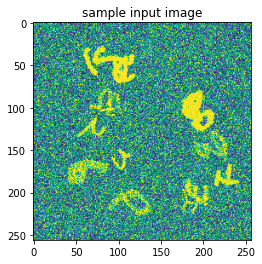

예측값 :  Index(['a', 'b', 'c', 'd', 'e', 'g', 'o', 'p', 'q', 's', 'w'], dtype='object')


In [ ]:
# gpu에 올라가 있는 tensor -> cpu로 이동 -> numpy array로 변환
sample_images = images.cpu().detach().numpy()
sample_prob = probs
#sample_labels = labels

idx = 1
plt.imshow(sample_images[idx][0])
plt.title("sample input image")
plt.show()

print('예측값 : ',dirty_mnist_answer.columns[1:][sample_prob[idx] > 0.5])

# 8. 제출파일 생성

In [ ]:
sample_submission = pd.read_csv("sample_submission.csv")
sample_submission.iloc[:,1:] = predictions_mean
sample_submission.to_csv(path + model_path + "baseline_prediction.csv", index = False)
sample_submission

,index,a,b,c,d,e,f,g,h,i,j,k,l,m,n,o,p,q,r,s,t,u,v,w,x,y,z
0,50000,0,0,0,0,0,1,0,1,0,0,1,0,1,1,0,0,0,0,0,1,0,0,1,1,1,1
1,50001,0,1,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0
2,50002,1,1,1,1,1,1,1,0,0,1,0,0,1,1,0,1,1,0,1,0,1,1,1,0,0,1
3,50003,1,1,0,0,0,1,1,1,0,0,1,0,1,1,0,0,1,1,1,1,0,0,1,1,0,1
4,50004,1,1,0,1,1,0,1,0,0,0,0,0,0,0,1,1,1,0,1,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4995,54995,0,0,0,0,0,1,0,1,0,0,1,0,1,0,1,0,0,0,0,1,0,0,0,1,1,1
4996,54996,0,1,0,1,0,0,1,0,0,0,0,0,0,0,1,1,1,0,1,0,0,0,0,0,0,0
4997,54997,0,0,0,0,0,0,0,1,1,0,1,1,0,0,1,0,0,0,0,0,0,0,0,0,1,0
4998,54998,0,1,1,0,1,0,0,0,1,0,0,1,0,0,0,1,0,0,0,0,1,1,0,0,0,0
